In [1]:
import os 
os.chdir('../../')

In [2]:
from backbones.sana import SANA

# 사용 예
model = SANA()
print(model)

/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Loading pipeline components...: 100%

In [5]:
import matplotlib.pyplot as plt

def show_compare(euler_img, dpm_img, unipc_img):
    fig, axes = plt.subplots(1, 3, figsize=(18, 10))
    axes[0].imshow(euler_img); axes[0].axis('off'); axes[0].set_title('Euler')
    axes[1].imshow(dpm_img);  axes[1].axis('off'); axes[1].set_title('DPM-Solver')
    axes[2].imshow(unipc_img);  axes[2].axis('off'); axes[2].set_title('Dual Log DPM-Solver')
    plt.tight_layout()
    plt.show()


  5%|▌         | 10/200 [00:00<00:13, 14.58it/s]

100%|██████████| 200/200 [00:13<00:00, 14.33it/s]


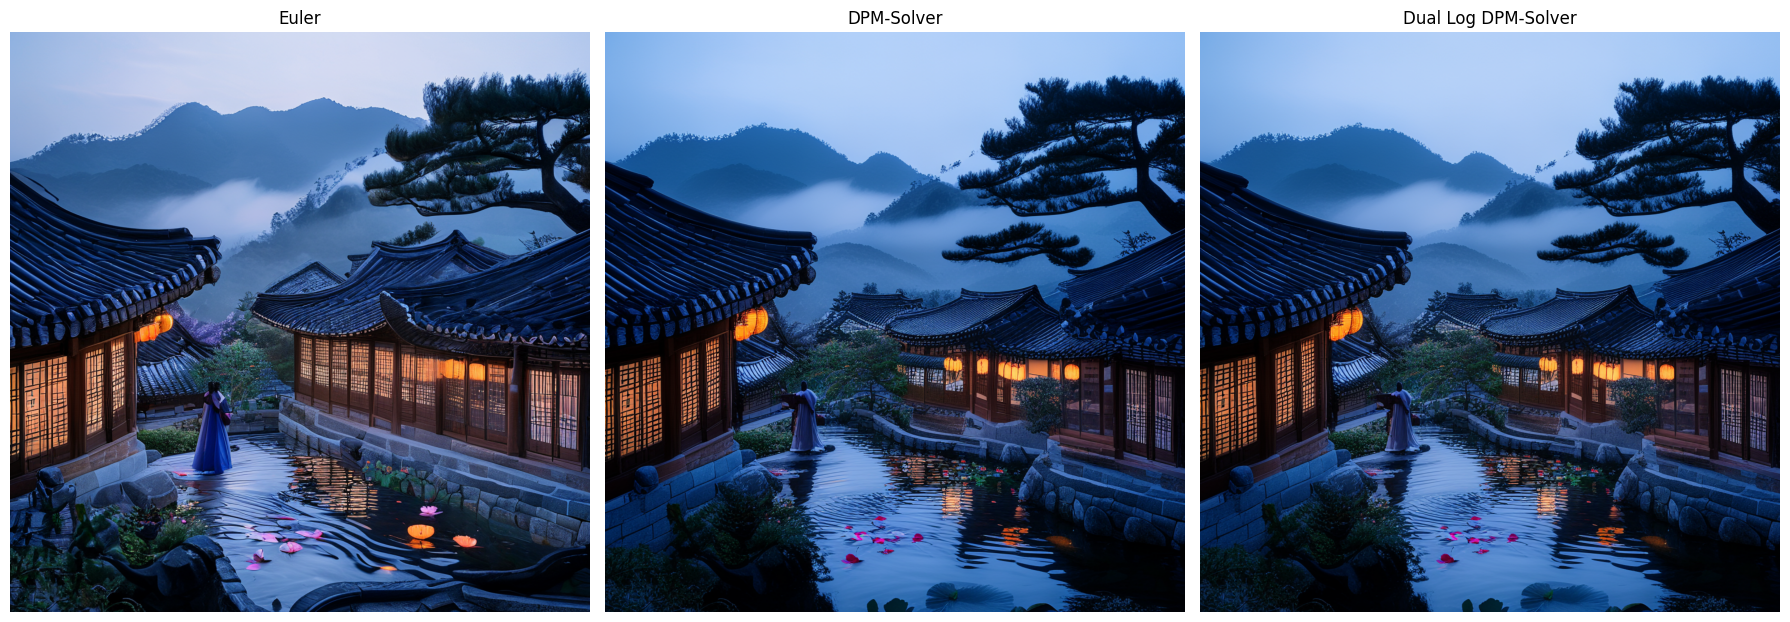

In [ ]:
from solvers.euler_solver import Euler_Solver
from solvers.dpm_solver import DPM_Solver
from solvers.dual.dual_log_dpm_solver import Dual_Log_DPM_Solver

pos_texts = ["A serene twilight view of a traditional Korean hanok village nestled between misty mountain slopes: curved midnight-blue tiled eaves, softly glowing paper lanterns swaying in the breeze; ancient pine trees arching over stone pathways; intricate wooden lattice windows casting delicate shadows; a lone scholar in flowing hanbok practicing calligraphy beside a koi pond with lotus petals drifting on the water; cinematic 8K ultra-realism with dynamic volumetric moonlight filtering through morning mist; painterly strokes blending classical Joseon-era ink wash with modern hyperrealism; shot on RED Monstro 8K, 50 mm f/1.2 lens; subtle film grain; maximum fidelity; emotional atmosphere."]
neg_texts = ["lowres, bad anatomy, deformed, blurry, pixelated, oversaturated, underexposed, overexposed, artifact, jpeg artifacts, watermark, text, logo, extra limbs, mutated hands, unnatural colors, noisy background, out of focus, poor composition, cultural clichés, stereotype exaggeration, flat lighting, glitch"]

model_fn, noise_schedule, latents = model.get_model_fn(pos_conds=pos_texts, neg_conds=neg_texts, guidance_scale=4.5, seeds=[42])

solver = Euler_Solver(model_fn, noise_schedule, algorithm_type='vector_prediction')
euler_latents = solver.sample(latents, steps=200, skip_type='time_uniform_flow', flow_shift=3.0)
euler_samples = model.decode_vae(euler_latents)[0]

solver = DPM_Solver(model_fn, noise_schedule, algorithm_type='data_prediction')
dpm1_latents = solver.sample(latents, steps=8, order=2, skip_type="time_uniform_flow", method="multistep", flow_shift=3.0)
dpm1_samples = model.decode_vae(dpm1_latents)[0]

solver = Dual_Log_DPM_Solver(model_fn, noise_schedule, algorithm_type='dual_prediction')
dpm2_latents = solver.sample(latents, steps=8, order=2, skip_type="time_uniform_flow", method="multistep", flow_shift=3.0)
dpm2_samples = model.decode_vae(dpm2_latents)[0]

show_compare(euler_samples, dpm1_samples, dpm2_samples)

In [20]:
import torch.nn.functional as F

for NFE in [3, 5, 6, 8, 10]:
    solver = DPM_Solver(model_fn, noise_schedule, algorithm_type='data_prediction')
    dpm1_latents = solver.sample(latents, steps=NFE, order=2, skip_type="time_uniform_flow", method="multistep", flow_shift=3.0)
    dpm1_samples = model.decode_vae(dpm1_latents)[0]

    solver = Dual_Log_DPM_Solver(model_fn, noise_schedule, algorithm_type='dual_prediction')
    dpm2_latents = solver.sample(latents, steps=NFE, order=2, skip_type="time_uniform_flow", method="multistep", flow_shift=3.0)
    dpm2_samples = model.decode_vae(dpm2_latents)[0]
    
    print('NFE :', NFE)
    print(F.mse_loss(euler_latents, dpm1_latents).item())
    print(F.mse_loss(euler_latents, dpm2_latents).item())

NFE : 3
0.9065735340118408
0.8799751996994019
NFE : 5
0.74674391746521
0.7478733062744141
NFE : 6
0.5193856954574585
0.5196373462677002
NFE : 8
0.22625577449798584
0.22214317321777344
NFE : 10
0.13620328903198242
0.13762852549552917
